In [31]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np

In [32]:
import tensorflow as tf

# GPUを無効化
tf.config.set_visible_devices([], 'GPU')

In [33]:
DATA_TYPE1 = 'gr'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleEmbedding'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'WaterClassifyingRuleEmbedding_success_protein_test.txt')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)
print(test_data.shape)

(1728, 21, 21, 21, 1)


In [34]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
BN = True
class_num = 2

In [35]:
checkpoint_dir = f'../checkpoints/valid/smoothing/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN, class_num=class_num)
model.load_weights(latest_checkpoint)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 21, 21,    │          0 │ -                 │
│ (InputLayer)        │ 21, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 21, 21,    │        224 │ input_layer_1[0]… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_9[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 21, 21,    │      1,736 │ activation_7[0][… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_10[0][0]   │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 21, 21,    │      1,736 │ activation_8[0][… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_11[0][0]   │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 21, 21,    │          0 │ batch_normalizat… │
│                     │ 21, 8)            │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 21, 21,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 10, 10,    │          0 │ activation_9[0][… │
│ (MaxPooling3D)      │ 10, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_12 (Conv3D)  │ (None, 10, 10,    │      3,472 │ max_pooling3d_3[… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         64 │ conv3d_12[0][0]   │
│ (BatchNormalizatio… │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_13 (Conv3D)  │ (None, 10, 10,    │      6,928 │ activation_10[0]… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_14 (Conv3D)  │ (None, 10, 10,    │        144 │ max_pooling3d_3[

 Total params: 58,114 (227.01 KB)

 Trainable params: 57,778 (225.70 KB)

 Non-trainable params: 336 (1.31 KB)

/home/ito/research/src/yuki_research/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
prediction = model.predict(test_data)
# prediction_values = prediction.reshape(prediction.shape[0])
# predicted_label = prediction.round()


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [37]:
prediction

array([[0.54393065, 0.45606935],
       [0.08653057, 0.91346943],
       [0.9406859 , 0.05931403],
       ...,
       [0.08511156, 0.9148884 ],
       [0.25587848, 0.7441215 ],
       [0.19326352, 0.80673647]], dtype=float32)

In [38]:
prediction_values = prediction[:, 1]
predicted_label = np.argmax(prediction, axis=1)

In [39]:
predicted_label.shape
predicted_label

array([0, 1, 0, ..., 1, 1, 1])

In [40]:
test_data_label[6],predicted_label[6]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>,
 0)

In [41]:
test_data_label

<tf.Tensor: shape=(1728, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [42]:
test_data_label = np.argmax(test_data_label, axis=1)

cm1 = confusion_matrix(test_data_label, predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm1.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm1)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[547 266]
 [ 81 834]]
True Negative (TN): 547
False Positive (FP): 266
False Negative (FN): 81
True Positive (TP): 834
0.8710191082802548


In [43]:
# 混合行列のそれぞれの要素の正解データのラベルの配列を取得する（どのテストデータがどのように予測されているかを確認するため）
tn_index = []
fp_index = []
fn_index = []
tp_index = []

for i, (true_label, pred_label) in enumerate(zip(test_data_label, predicted_label)):
    if true_label == 0 and pred_label == 0:
        tn_index.append(i)
    elif true_label == 0 and pred_label == 1:
        fp_index.append(i)
    elif true_label == 1 and pred_label == 0:
        fn_index.append(i)
    elif true_label == 1 and pred_label == 1:
        tp_index.append(i)

In [44]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()

In [45]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.9114754, 'precision': 0.7581818, 'accuracy': 0.7991898, 'specificity': 0.67281675, 'dice_coefficient': 0.827877, 'auc': 0.894891}


In [46]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [47]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.5873321

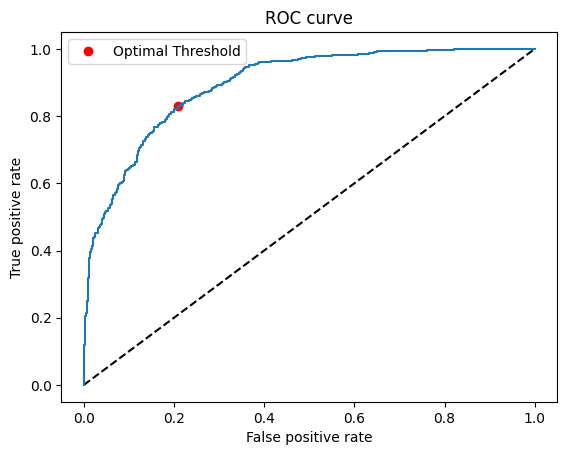

In [48]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [49]:
np.where(tpr > 0.70)[0]


array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 34

In [50]:
tpr[2356]
# thresholds[2748]

IndexError: index 2356 is out of bounds for axis 0 with size 466

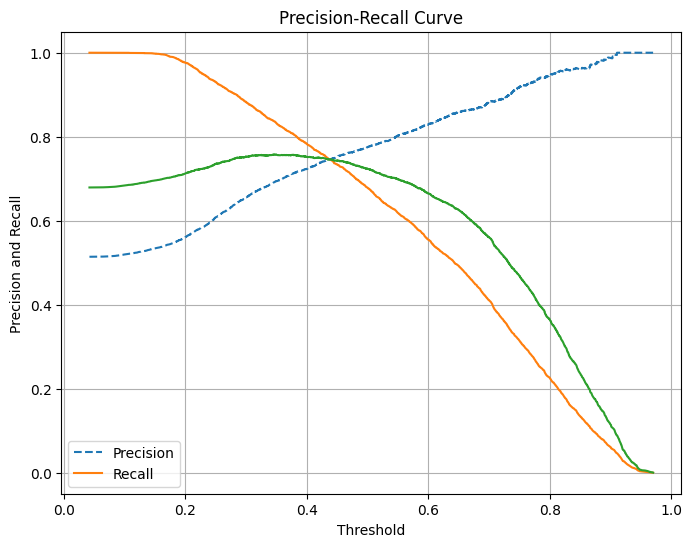

0.34910884
0.8341797866937531 0.6945031712473573


In [ ]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall曲線の計算
precisions, recalls, thresholds = precision_recall_curve(test_data_label, prediction_values)
f1 = 2 * precisions * recalls / (precisions + recalls)
# Precision-Recall曲線の描画
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1[:-1])
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
print(thresholds[np.argmax(f1)])
print(recalls[np.argmax(f1)], precisions[np.argmax(f1)])

# # 最適な閾値の選定（ここではrecallがある一定以上の場合の閾値を選ぶ例）
# target_recall = 0.8  # 目標とするrecall値
# optimal_threshold = 0.5  # 初期値

# for precision, recall, threshold in zip(precisions, recalls, thresholds):
#     if recall >= target_recall:
#         optimal_threshold = threshold
#         break

# print(f"Optimal threshold for target recall {target_recall}: {optimal_threshold}")


In [51]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_threshold_youden = 0.45
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [52]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

f2 = fbeta_score(test_data_label, optimal_predicted_label, beta=1)


auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [53]:
f2

0.8338918142651986

In [54]:
cm2 = confusion_matrix(test_data_label, optimal_predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm2.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm2)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[510 303]
 [ 44 871]]
True Negative (TN): 510
False Positive (FP): 303
False Negative (FN): 44
True Positive (TP): 871
0.9205776173285198


In [55]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(),"f2": f2, "auc": auc_value})

{'recall': 0.9519126, 'precision': 0.741908, 'accuracy': 0.7991898, 'specificity': 0.6273063, 'dice_coefficient': 0.8339713, 'f2': 0.8338918142651986, 'auc': 0.894891}


In [27]:
def calculate_metrics(confusion_matrix1, confusion_matrix2):
    # Sum the confusion matrices
    total_confusion_matrix = confusion_matrix1 + confusion_matrix2

    # Extract values
    TN = total_confusion_matrix[0, 0]
    FP = total_confusion_matrix[0, 1]
    FN = total_confusion_matrix[1, 0]
    TP = total_confusion_matrix[1, 1]

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    dice_coefficient = 2 * TP / (2 * TP + FP + FN)
    auc = (recall + specificity) / 2

    # Store metrics in a dictionary
    metrics = {
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'specificity': specificity,
        'dice_coefficient': dice_coefficient,
        'auc': auc
    }

    return metrics

In [28]:
cm1 = [[1884,  504],
 [ 814 ,1779]]

cm1 = np.array([[1706, 682],
 [ 655, 1938]])

cm2 = np.array([[3024, 1085],
 [1196 ,3224]])

In [29]:
cm1 + cm2

array([[4730, 1767],
       [1851, 5162]])

In [30]:
print(calculate_metrics(cm1, cm2))

{'recall': 0.7360615998859261, 'precision': 0.7449848462981671, 'accuracy': 0.7321983715766099, 'specificity': 0.7280283207634293, 'dice_coefficient': 0.740496341988237, 'auc': 0.7320449603246777}
